### Oil type by origin "Pacific" (general attribution)
Goal: Determine general case of fuel allocation 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

master_dir  = '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/'
master_file = 'master.yaml'

with open(f'{master_dir}{master_file}') as file:
    master = yaml.safe_load(file)

vessel_types = master['categories']['tank_vessels']
fuel_types   = master['categories']['fuel_type']

In [3]:
vessel_types

['tanker', 'atb', 'barge']

In [4]:
# Import columns are: (G) Deliverer, (H) Receiver, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

#### Extract cargo data transferred from vessel to facility

In [5]:
# list of names in DOE dataset that are used as "DelivererTypeDescription" for vessel transfers
vessel_names = ['TANK SHIP', 'TANK BARGE', 'TUGBOAT']
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]
cargo_to_facility = cargo_data[ cargo_data['ReceiverTypeDescription']=='Facility' ]
cargo_from_tank   = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TANK SHIP' ]
cargo_from_barge  = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TANK BARGE' ] 
cargo_from_tug    = cargo_to_facility[ cargo_to_facility['DelivererTypeDescription'] == 'TUGBOAT' ]

# reset indices so they increase chronologically from 0 instead of keeping parent index values
cargo_from_tank.reset_index( drop=True, inplace=True )
cargo_from_barge.reset_index( drop=True, inplace=True )
cargo_from_tug.reset_index( drop=True, inplace=True )

In [6]:
[nrows,ncols] = cargo_from_barge.shape

In [7]:
# create ATB and tank barge dataframes
cargo_from_atb = pd.DataFrame(columns = cargo_from_barge.columns)
for row in range(nrows):
    if 'ITB' in cargo_from_barge.Deliverer[row] or 'ATB' in cargo_from_barge.Deliverer[row]:
        cargo_from_atb = cargo_from_atb.append( cargo_from_barge.iloc[row] )
        
for row in range(nrows):
    if 'ITB' in cargo_from_barge.Deliverer[row] or 'ATB' in cargo_from_barge.Deliverer[row]:        
        cargo_from_barge = cargo_from_barge.drop([row])

# reset indexing        
cargo_from_atb.reset_index( drop=True, inplace=True )

In [8]:
# concatenate tank barge dataframes
cargo_from_barge = pd.concat([cargo_from_barge, cargo_from_tug])

# reset indexing
cargo_from_barge.reset_index( drop=True, inplace=True )

### Total up the volume of fuel by fuel category for vessel types used in this study

In [9]:
# create dictionary structure
Pacific = {}
for vessel in vessel_types:
    Pacific[f'{vessel}']={}
    for fuel in fuel_types:
        Pacific[f'{vessel}'][f'{fuel}']={}
        Pacific[f'{vessel}'][f'{fuel}']['total_gallons']=0
        Pacific[f'{vessel}'][f'{fuel}']['number_of_transfers']=0
        Pacific[f'{vessel}'][f'{fuel}']['percent_of_total']=0

#### Tankers

In [10]:
[nrows,ncols] = cargo_from_tank.shape
label = 'tanker'
for row in range(nrows):
    
    if 'CRUDE' in cargo_from_tank.Product[row]:
        Pacific[f'{label}']['akns']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['akns']['number_of_transfers'] += 1

    elif cargo_from_tank.Product[row] == 'BUNKER OIL/HFO':
        Pacific[f'{label}']['bunker']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['bunker']['number_of_transfers'] += 1

    elif cargo_from_tank.Product[row] == 'GASOLINE':
        Pacific[f'{label}']['gas']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['gas']['number_of_transfers'] += 1

    elif cargo_from_tank.Product[row] == 'JET FUEL/KEROSENE':
        Pacific[f'{label}']['jet']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_from_tank.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        Pacific[f'{label}']['diesel']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['diesel']['number_of_transfers'] += 1

    else:
        Pacific[f'{label}']['other']['total_gallons'] += cargo_from_tank.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['other']['number_of_transfers'] += 1    

In [11]:
Pacific[f'{label}']['other']['total_gallons']

240552010

#### ATBs

In [12]:
[nrows,ncols] = cargo_from_atb.shape
label = 'atb'
for row in range(nrows):
    
    if 'CRUDE' in cargo_from_atb.Product[row]:
        ### WHY DOES ADDING A .ITEM() HERE GIVE AN ERROR WHEN IT DOESN'T ABOVE?
        Pacific[f'{label}']['akns']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[f'{label}']['akns']['number_of_transfers'] += 1

    elif cargo_from_atb.Product[row] == 'BUNKER OIL/HFO':
        Pacific[f'{label}']['bunker']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[f'{label}']['bunker']['number_of_transfers'] += 1

    elif cargo_from_atb.Product[row] == 'GASOLINE':
        Pacific[f'{label}']['gas']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[f'{label}']['gas']['number_of_transfers'] += 1

    elif cargo_from_atb.Product[row] == 'JET FUEL/KEROSENE':
        Pacific[f'{label}']['jet']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[f'{label}']['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_from_atb.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        Pacific[f'{label}']['diesel']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[f'{label}']['diesel']['number_of_transfers'] += 1

    else:
        Pacific[f'{label}']['other']['total_gallons'] += cargo_from_atb.TransferQtyInGallon[row]
        Pacific[f'{label}']['other']['number_of_transfers'] += 1   

#### Barges

In [13]:
[nrows,ncols] = cargo_from_barge.shape
label = 'barge'

for row in range(nrows):
    
    if 'CRUDE' in cargo_from_barge.Product[row]:
        Pacific[f'{label}']['akns']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['akns']['number_of_transfers'] += 1

    elif cargo_from_barge.Product[row] == 'BUNKER OIL/HFO':
        Pacific[f'{label}']['bunker']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['bunker']['number_of_transfers'] += 1

    elif cargo_from_barge.Product[row] == 'GASOLINE':
        Pacific[f'{label}']['gas']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['gas']['number_of_transfers'] += 1

    elif cargo_from_barge.Product[row] == 'JET FUEL/KEROSENE':
        Pacific[f'{label}']['jet']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_from_barge.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        Pacific[f'{label}']['diesel']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['diesel']['number_of_transfers'] += 1

    else:
        Pacific[f'{label}']['other']['total_gallons'] += cargo_from_barge.TransferQtyInGallon[row].item()
        Pacific[f'{label}']['other']['number_of_transfers'] += 1   


#### Determine percent oil for each oil type

In [14]:
for vessel in vessel_types:

    # first get the total transfers over all fuel types
    total = sum([ Pacific[f'{vessel}'][f'{fuel}']['total_gallons'] for fuel in fuel_types ])

    for fuel in fuel_types:
  
        # next calculate percentages
        if total != 0:
            Pacific[f'{vessel}'][f'{fuel}']['percent_of_total'] = round(Pacific[f'{vessel}'][f'{fuel}']['total_gallons'] / total, 2)
  

In [17]:
with open(r'./Pacific_origin.yaml', 'w') as file:
    documents = yaml.safe_dump(Pacific, file)

#### Plot results

In [18]:
fuel_types

['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']

Text(0.5,1,'tanker fuel allocation for origin = Pacific')

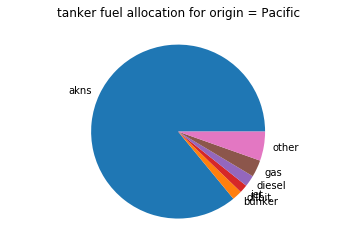

In [20]:
label = 'tanker'
Pacific_tank = [ Pacific[f'{label}']['akns']['total_gallons'], 
                Pacific[f'{label}']['bunker']['total_gallons'], 
                Pacific[f'{label}']['dilbit']['total_gallons'], 
                Pacific[f'{label}']['jet']['total_gallons'], 
                Pacific[f'{label}']['diesel']['total_gallons'], 
                Pacific[f'{label}']['gas']['total_gallons'], 
                Pacific[f'{label}']['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(Pacific_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = Pacific')

Text(0.5,1,'atb fuel allocation for origin = Pacific')

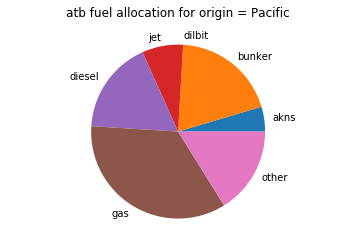

In [21]:
label = 'atb'
Pacific_tank = [ Pacific[f'{label}']['akns']['total_gallons'], 
                Pacific[f'{label}']['bunker']['total_gallons'], 
                Pacific[f'{label}']['dilbit']['total_gallons'], 
                Pacific[f'{label}']['jet']['total_gallons'], 
                Pacific[f'{label}']['diesel']['total_gallons'], 
                Pacific[f'{label}']['gas']['total_gallons'], 
                Pacific[f'{label}']['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(Pacific_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = Pacific')

Text(0.5,1,'barge fuel allocation for origin = Pacific')

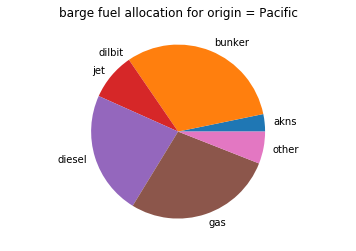

In [22]:
label = 'barge'
Pacific_tank = [ Pacific[f'{label}']['akns']['total_gallons'], 
                Pacific[f'{label}']['bunker']['total_gallons'], 
                Pacific[f'{label}']['dilbit']['total_gallons'], 
                Pacific[f'{label}']['jet']['total_gallons'], 
                Pacific[f'{label}']['diesel']['total_gallons'], 
                Pacific[f'{label}']['gas']['total_gallons'], 
                Pacific[f'{label}']['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(Pacific_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = Pacific')